## Titanic 

use machine learning to create a model that predicts which passengers survived the Titanic shipwreck

Data Dictionary <br>

survival:	Survival	0 = No, 1 = Yes <br>
pclass:	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd <br>
sex:	Sex	<br>
Age:	Age in years<br>
sibsp:	 of siblings / spouses aboard the Titanic<br>  	
parch:	 of parents / children aboard the Titanic  <br>
ticket:	Ticket number<br>	
fare:	Passenger fare	<br>
cabin:	Cabin number<br>	
embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton<br>

<img src= "https://www.veribilimiokulu.com/wp-content/uploads/2019/09/1.png.webp">
<a href ="https://www.kaggle.com/competitions/titanic/data"
target=_blank> you can download the data file here</a>"<br>
@misc{titanic,
    author = {Will Cukierski},
    title = {Titanic - Machine Learning from Disaster},
    publisher = {Kaggle},
    year = {2012},
    url = {https://kaggle.com/competitions/titanic}
}



In [ ]:
## import the necessary packages

In [1]:
import pandas as pd
pd.set_option("display.max_columns" ,50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

import warnings 
warnings.filterwarnings("ignore")

## import data 

In [2]:
train= pd.read_csv("ttrain.csv")
test= pd.read_csv("ttest.csv")

## EDA

In [3]:
# for eda we need to combine test and train dataset
test["Survived"] = -1
combined = pd.concat([test,train],sort= False).reset_index(drop=True)

In [4]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Pclass       1309 non-null   int64  
 2   Name         1309 non-null   object 
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Ticket       1309 non-null   object 
 8   Fare         1308 non-null   float64
 9   Cabin        295 non-null    object 
 10  Embarked     1307 non-null   object 
 11  Survived     1309 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB


In [5]:
combined.shape

(1309, 12)

In [6]:
combined.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,1309.0,655.000000,378.020061,1.00,328.0000,655.0000,982.000,1309.0000
Pclass,1309.0,2.294882,0.837836,1.00,2.0000,3.0000,3.000,3.0000
Age,1046.0,29.881138,14.413493,0.17,21.0000,28.0000,39.000,80.0000
SibSp,1309.0,0.498854,1.041658,0.00,0.0000,0.0000,1.000,8.0000
Parch,1309.0,0.385027,0.865560,0.00,0.0000,0.0000,0.000,9.0000
Fare,1308.0,33.295479,51.758668,0.00,7.8958,14.4542,31.275,512.3292
Survived,1309.0,-0.058060,0.760044,-1.00,-1.0000,0.0000,1.000,1.0000


In [7]:
combined.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Survived          0
dtype: int64

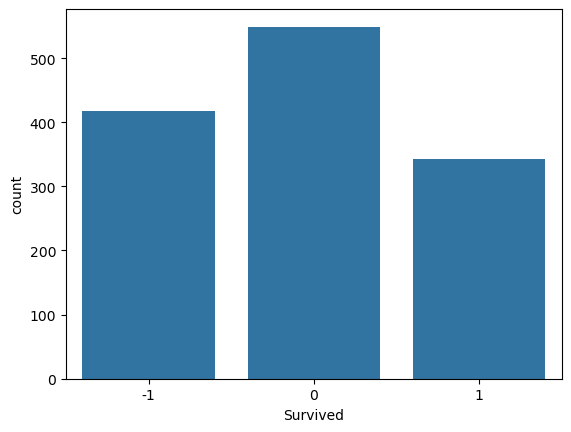

In [8]:
sns.countplot(x = combined["Survived"]);

([0, 1, 2], [Text(0, 0, '-1'), Text(1, 0, '0'), Text(2, 0, '1')])

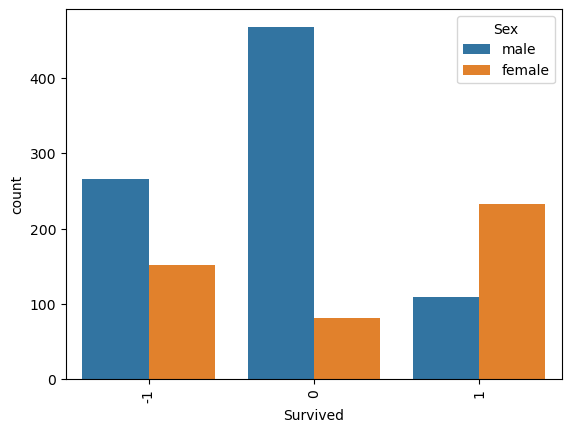

In [9]:
sns.countplot(x= combined["Survived"],hue= combined.Sex)
plt.xticks(rotation=90)

<Axes: xlabel='Age', ylabel='Count'>

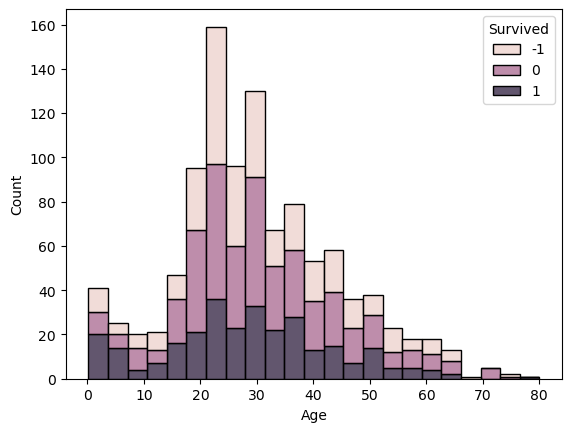

In [10]:
sns.histplot(data=combined, x="Age" ,hue = "Survived",multiple= "stack")

([0, 1, 2], [Text(0, 0, '-1'), Text(1, 0, '0'), Text(2, 0, '1')])

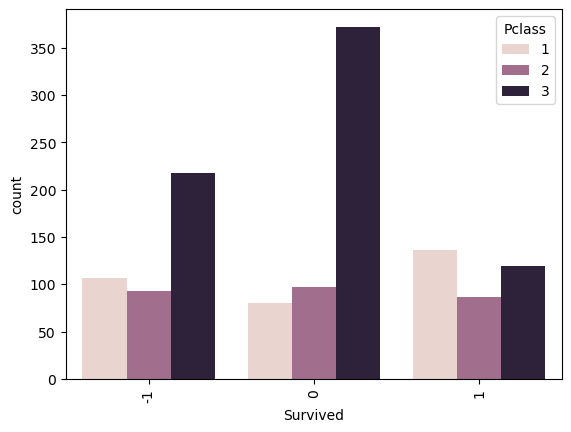

In [11]:
sns.countplot(x= combined["Survived"],hue= combined.Pclass)
plt.xticks(rotation=90)

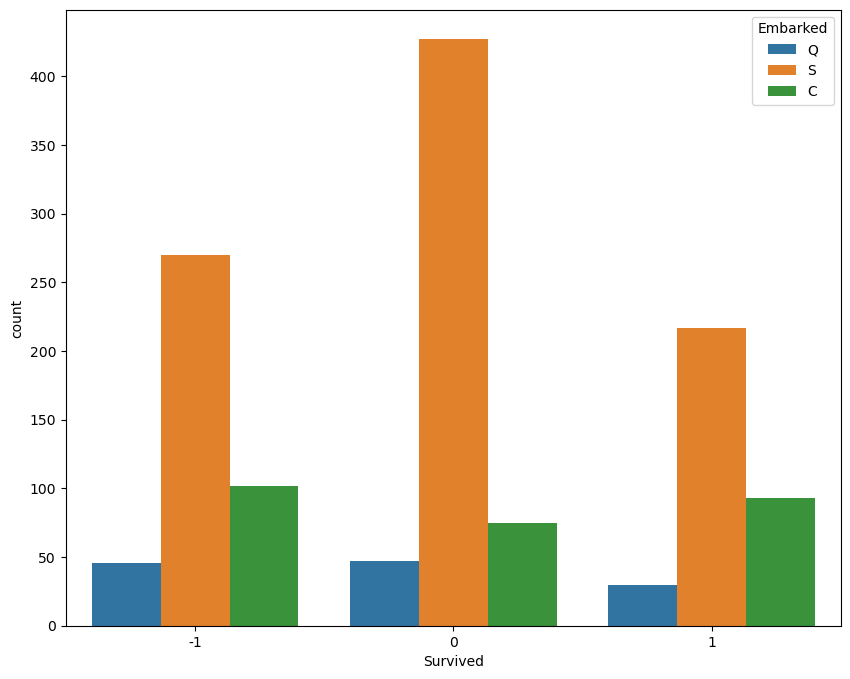

In [12]:
plt.figure(figsize=(10,8))
sns.countplot(x= combined["Survived"],hue= combined["Embarked"])
plt.savefig("branch.pdf",dpi=300)

### Handling Missing Values

In [13]:
combined['Age'].fillna((combined["Age"].mean()), inplace=True)

In [14]:
combined['Embarked'].fillna((combined['Embarked'].mode()[0]), inplace=True)

In [15]:
combined['Fare'].fillna((combined['Fare'].mode()[0]), inplace=True)

In [16]:
def predict_cabin(fare):
    if fare <= 51.233:
        return 'Unknown'  # Bu aralıkta çok fazla eksik olduğu için "Unknown" tahmini yapıyoruz.
    elif fare <= 102.466:
        return 'C'  # Orta Fare, C kabin daha yaygın
    elif fare <= 153.699:
        return 'B'  # Daha yüksek Fare, B kabin olabilir.
    elif fare <= 204.932:
        return 'A'  # En yüksek farelerden biri, genellikle A kabin
    elif fare <= 256.165:
        return 'A'  # Yüksek Fare, A kabin
    elif fare <= 307.398:
        return 'T'  # Yüksek farede farklı bir kabin
    else:
        return 'T'  # En üst seviye, farklı kabin olabilir.

# Eksik cabin verilerini doldurma
combined['Cabin'] = combined.apply(lambda row: predict_cabin(row['Fare']) if pd.isna(row['Cabin']) else row['Cabin'], axis=1)


In [17]:
combined.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Survived       0
dtype: int64

<Axes: >

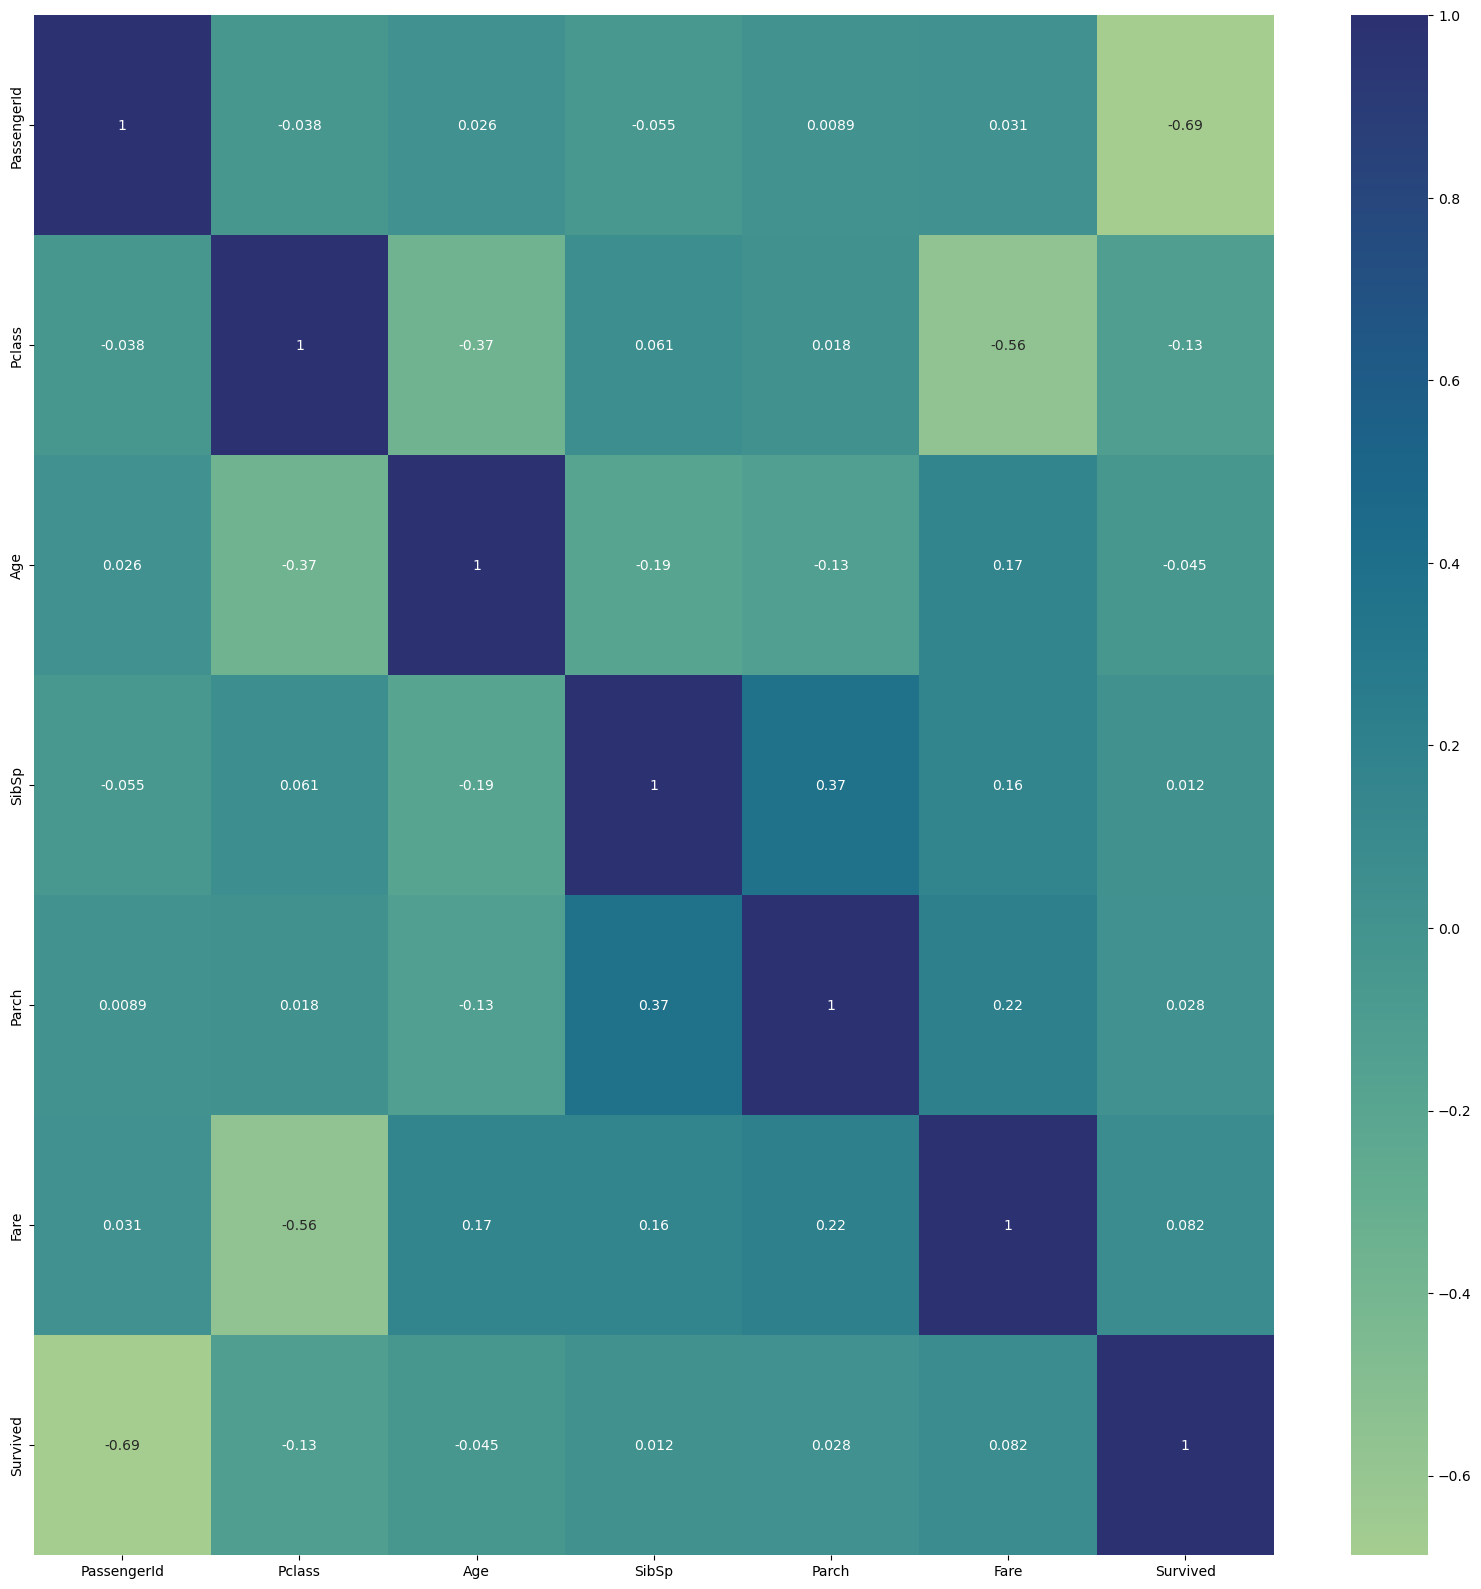

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(combined.corr(numeric_only=True),annot= True, cmap="crest")

In [19]:
abs(combined.corr(numeric_only=True)["Survived"].sort_values(ascending=False))

Survived       1.000000
Fare           0.081952
Parch          0.028196
SibSp          0.012470
Age            0.044959
Pclass         0.126769
PassengerId    0.687207
Name: Survived, dtype: float64

categorize

## outliers 

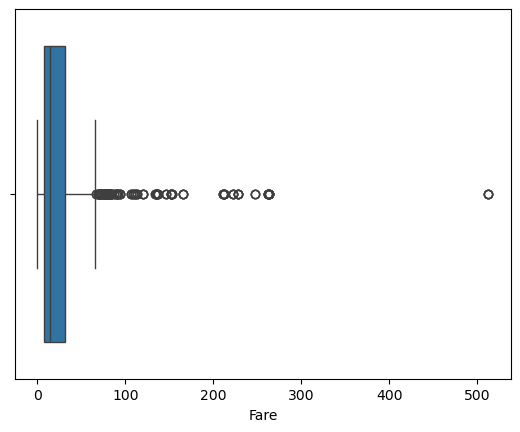

In [20]:
sns.boxplot(x=combined['Fare'])
plt.show()

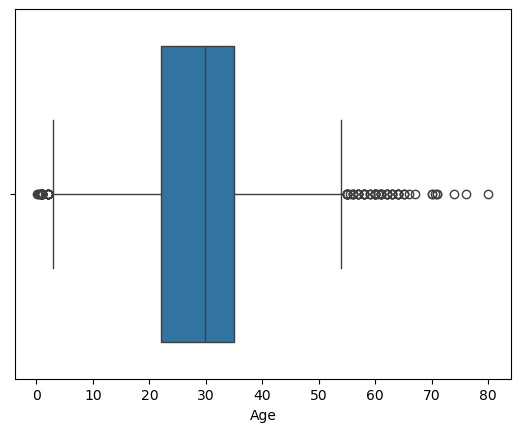

In [21]:
sns.boxplot(x=combined['Age'])
plt.show()

In [22]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]




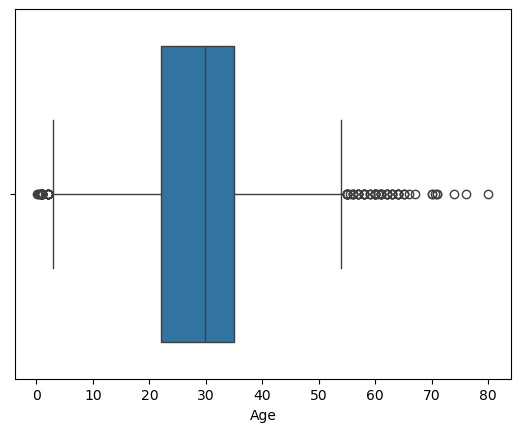

In [23]:
sns.boxplot(x=combined['Age'])
plt.show()

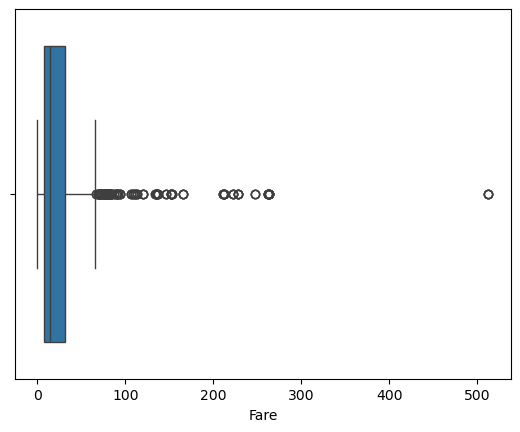

In [24]:
sns.boxplot(x=combined["Fare"])
plt.show()

In [25]:
combined["Fare"]= combined["Fare"]**2
combined["Age"]= combined["Age"]**2
combined["Pclass"]= combined["Pclass"]**2

In [26]:
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1

In [27]:
combined = combined.drop(columns=['SibSp', 'Parch',"Name"])

In [28]:
combined['Isalone'] = combined['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [29]:
combined['Fare_Per_Person'] = combined['Fare'] / combined['FamilySize']

In [30]:
combined = pd.get_dummies(combined, drop_first= True)

In [31]:
train = combined[combined['Survived'] != -1] 
test = combined[combined['Survived'] == -1]  

In [32]:
train_cleaned = remove_outliers_iqr(train, 'Age')
train_cleaned = remove_outliers_iqr(train_cleaned, 'Fare')

In [33]:
x = train_cleaned.drop(columns='Survived')
y = train_cleaned['Survived']

# Test setinde 'Survived' sütununu kaldırma
x_test = test.drop(columns=['Survived'])


In [34]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [35]:
h= GradientBoostingClassifier()

In [36]:
h.fit(x_train, y_train)

GradientBoostingClassifier()

In [37]:
hpred= h.predict(x_val)

In [38]:
print(classification_report(hpred,y_val))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89        98
           1       0.69      0.81      0.74        36

    accuracy                           0.85       134
   macro avg       0.81      0.84      0.82       134
weighted avg       0.86      0.85      0.85       134



In [39]:
confusion_matrix(hpred,y_val)

array([[85, 13],
       [ 7, 29]], dtype=int64)

In [40]:
y_test_pred = h.predict(x_test)

In [41]:
submission6 = pd.DataFrame({
    'PassengerId': test['PassengerId'],  # Test setindeki PassengerId'yi ekleyin
    'Survived': y_test_pred  # Tahminler
})

# CSV dosyasını kaydedin
submission6.to_csv('submission6.csv', index=False)